In [153]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

random.seed(148253)

In [154]:
df1 = pd.read_csv('Data/TSPA.csv', header = None, sep = ';')
df2 = pd.read_csv('Data/TSPB.csv', header = None, sep = ';')
df3 = pd.read_csv('Data/TSPC.csv', header = None, sep = ';')
df4 = pd.read_csv('Data/TSPD.csv', header = None, sep = ';')

In [155]:
df1

,0,1,2
0,1510,353,84
1,3042,123,483
2,2145,389,1462
3,1030,365,1986
4,2125,360,145
...,...,...,...
195,1023,1258,197
196,3192,1271,1183
197,3735,1879,1461
198,3983,299,1309


### Distance matrix
Node costs included

In [156]:
def calculate_distance(city1, city2):
    return round(math.sqrt((city1[0]-city2[0])**2 + (city1[1]-city2[1])**2))

In [157]:
def create_distance_matrix(df):
    #distance_matrix = [[df.iloc[j, 2] for j in range(df.shape[0])] for i in range(df.shape[0])]
    distance_matrix = [[0 for j in range(df.shape[0])] for i in range(df.shape[0])]
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            if i == j:
                distance_matrix[i][j] += 1000000
                break
            dist = calculate_distance(df.values[i][:2], df.values[j][:2])
            distance_matrix[i][j] += dist
            distance_matrix[j][i] += dist
    return distance_matrix

### Get cost

In [158]:
def get_cost(a, b, df, distance_matrix):
    return distance_matrix[a][b] + df.values[b][2]

### Helpful debugging function for checking the length of the cycle

In [159]:
def check_cycle_length(df, path):
    distance_matrix = create_distance_matrix(df)
    dist = 0
    path = path[::-1]
    for index, node in enumerate(path[:-1]):
        dist += get_cost(node, path[(index+1) % len(path)], df, distance_matrix)
    dist += get_cost(path[-1], path[0], df, distance_matrix)
    return dist

### Random Solution

In [160]:
def random_TSP(df, distance_matrix):
    path = random.sample(range(0, len(distance_matrix)), math.ceil(len(distance_matrix) / 2))
    dist = 0
    for index, item in enumerate(path):
        dist += get_cost(item, path[(index+1) % len(path)], df, distance_matrix)
    return dist, path

### Nearest Neighbour

In [161]:
def nearest_TSP(df, distance_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    for i in range(cycle_length - 1):
        shortest_distance = 1000000
        shortest_city = -1

        for j in range(len(distance_matrix)):
            if j in path:
                continue
            if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
                shortest_distance = get_cost(path[-1], j, df, distance_matrix)
                shortest_city = j
        
        path.append(shortest_city)
        dist += shortest_distance

    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    return dist, path

### Greedy Cycle

In [162]:
def greedy_TSP(df, distance_matrix, starting_city):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    shortest_distance = 1000000
    shortest_city = -1

    for j in range(len(distance_matrix)):
        if j in path:
            continue

        if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
            shortest_distance = get_cost(path[-1], j, df, distance_matrix)
            shortest_city = j
    
    path.append(shortest_city)
    dist += shortest_distance
    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    for i in range(0, cycle_length - 2):
        shortest_extra_distance = 1000000
        shortest_city = -1
        shortest_city_index = -1

        for j in range(len(distance_matrix)):
            if j in path:
                continue
            
            for k in range(len(path)):  
                extra_distance = (get_cost(path[k], j, df, distance_matrix) 
                                  + get_cost(j, path[(k+1) % len(path)], df, distance_matrix)
                                  - get_cost(path[k], path[(k+1) % len(path)], df, distance_matrix))
                
                if extra_distance < shortest_extra_distance:
                    shortest_extra_distance = extra_distance
                    shortest_city = j
                    shortest_city_index = k+1
            
        
        path.insert(shortest_city_index, shortest_city)
        dist += shortest_extra_distance
    


    return dist, path

### 2-Regret Cycle

In [163]:
def regret_TSP(df, D, starting_city, n=2):
    # based on your implementation of greedy regret
# 20s runtime for 200 iterations on my system
# performance similar to greedy cycle
    MAX_DIST = 1000000
    costs = []
    nodes = {}
    for idx, row in enumerate(df.values):
        x, y, cost = map(int, row)
        costs.append(cost)
        nodes[idx] = (x, y, cost)
    costs = [nodes[node][2] for node in list(nodes.keys())]

    best_neighbour = np.argmin(D[starting_city, :] + costs)
    path = [starting_city, best_neighbour, starting_city]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        M = np.zeros((len(nodes_available), len(edges)))
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            indices = np.array(nodes_available)
            M[:,edge_ix] = var[indices]

        M_tmp = np.copy(M)
        fc_best_increase = np.min(M_tmp)
        fc_new_node, fc_edge = np.argwhere(M_tmp == fc_best_increase)[0]

        # get second choice smallest value
        M_tmp[fc_new_node, fc_edge] = MAX_DIST
        sc_best_increase = np.min(M_tmp)
        sc_new_node, sc_edge = np.argwhere(M_tmp == sc_best_increase)[0]

        # get first choice regret
        M_tmp[fc_new_node,:] = MAX_DIST
        M_tmp[:,fc_edge] = MAX_DIST
        fc_second_best_increase = np.min(M_tmp)
        fc_regret = fc_best_increase + fc_second_best_increase

        # get second choice regret
        M_tmp[fc_new_node,:] = M[fc_new_node,:]
        M_tmp[:,fc_edge] = M[:,fc_edge]
        M_tmp[sc_new_node,:] = MAX_DIST
        M_tmp[:,sc_edge] = MAX_DIST

        sc_second_best_increase = np.min(M_tmp)
        sc_regret = sc_best_increase + sc_second_best_increase

        if fc_regret < sc_regret:
            replaced_edge = fc_edge
            best_node = nodes_available[fc_new_node]
        else:
            replaced_edge = sc_edge
            best_node = nodes_available[sc_new_node]

        path.insert(replaced_edge + 1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return path

### Greedy with weighted Sum Criterion

In [164]:
def weighted_TSP(df, distance_matrix, starting_city, n=2):
    dist = 0
    path = [starting_city]

    cycle_length = math.ceil(len(distance_matrix) / 2)

    shortest_distance = 1000000
    shortest_city = -1

    for j in range(len(distance_matrix)):
        if j in path:
            continue

        if get_cost(path[-1], j, df, distance_matrix) < shortest_distance:
            shortest_distance = get_cost(path[-1], j, df, distance_matrix)
            shortest_city = j
    
    path.append(shortest_city)
    dist += shortest_distance
    dist += get_cost(path[-1], starting_city, df, distance_matrix)

    for i in range(0, cycle_length - 2):
        
        best_score = -1000000
        best_node = 0
        best_location = 0
        extra_dist_for_best = 0

        for j in range(len(distance_matrix)):
            if j in path:
                continue

            best_location_for_this_node = 0
            top_n_scores = [1000000 for i in range(n)]

            for k in range(len(path)):
                extra_distance = (get_cost(path[k], j, df, distance_matrix) 
                                  + get_cost(j, path[(k+1) % len(path)], df, distance_matrix)
                                  - get_cost(path[k], path[(k+1) % len(path)], df, distance_matrix))

                for i in range(n):
                    if extra_distance < top_n_scores[i]:
                        top_n_scores.insert(i, extra_distance)
                        top_n_scores.pop()
                        if i == 0:
                            best_location_for_this_node = k
                        break
                
            n_regret = sum(top_n_scores[1:]) - top_n_scores[0]
            ### weighted element
            score = n_regret - top_n_scores[0]

            if score > best_score:
                best_score = score
                best_node = j
                best_location = best_location_for_this_node
                extra_dist_for_best = top_n_scores[0]

            
        path.insert(best_location+1, best_node)
        dist += extra_dist_for_best

    return dist, path

old best :
104829
124764
116240.25

76341.56
74563
78976

109774
128550
118806

### Compare methods

In [165]:
iterations = df1.shape[0] ### change hardcode to matrix size

nearest_bests = []
greedy_bests = []
regret_bests = []
weighted_bests = []

nearest_best_paths = []
greedy_best_paths = []
regret_best_paths = []
weighted_best_paths = []

random_best_paths = []

old_print = False
record = True
f = open("results.txt", "w")

for id, df in enumerate([df1, df2, df3, df4]):
    distance_matrix = create_distance_matrix(df)

    print(f'\n==============[Dataset {id+3}]==============')
    if old_print:
        print(f'RANDOM TSP')

        min_dist = 1000000
        max_dist = 0
        avg_dist = 0
        best_path = []

        for i in range(0, iterations):
            dist, path = random_TSP(df, distance_matrix)
            avg_dist += dist

            if dist < min_dist:
                min_dist = dist
                best_path = path
            if dist > max_dist:
                max_dist = dist

        avg_dist /= iterations

        random_best_paths.append(best_path)

        print(f'Best solution: {best_path}')
        print(f'Shortest distance: {min_dist}')
        print(f'Longest distance: {max_dist}')
        print(f'Average distance: {avg_dist}')

        if record:
            f.write(f"Dataset {id+3}\nRandom\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

        print(f'\nNEAREST NEIGHBOUR TSP')

        min_dist = 1000000
        max_dist = 0
        avg_dist = 0
        best_path = []

        for i in range(0, iterations):
            dist, path = nearest_TSP(df, distance_matrix, i)
            avg_dist += dist

            if dist < min_dist:
                min_dist = dist
                best_path = path
            if dist > max_dist:
                max_dist = dist

        avg_dist /= iterations

        assert check_cycle_length(df, best_path) == min_dist

        nearest_bests.append(min_dist)
        nearest_best_paths.append(best_path)

        print(f'Best solution: {best_path}')
        print(f'Shortest distance: {min_dist}')
        print(f'Longest distance: {max_dist}')
        print(f'Average distance: {avg_dist}')

        if record:
            f.write(f"Nearest Neighbour\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

        print(f'\nGREEDY CYCLE TSP')

        min_dist = 1000000
        max_dist = 0
        avg_dist = 0
        best_path = []

        for i in range(0, iterations):
            dist, path = greedy_TSP(df, distance_matrix, i)
            avg_dist += dist

            if dist < min_dist:
                min_dist = dist
                best_path = path
            if dist > max_dist:
                max_dist = dist

        avg_dist /= iterations

        assert check_cycle_length(df, best_path) == min_dist

        greedy_bests.append(min_dist)
        greedy_best_paths.append(best_path)

        print(f'Best solution: {best_path}')
        print(f'Shortest distance: {min_dist}')
        print(f'Longest distance: {max_dist}')
        print(f'Average distance: {avg_dist}')

        if record:
            f.write(f"Greedy Cycle\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

    print(f'\n2-REGRET CYCLE TSP')

    min_dist = 1000000
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = regret_TSP(df, distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        if dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    print(check_cycle_length(df, best_path), min_dist)
    assert check_cycle_length(df, best_path) == min_dist

    regret_bests.append(min_dist)
    regret_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Regret Cycle\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")
    
    print(f'\nWEIGHTED SUM CRITERION TSP')

    min_dist = 1000000
    max_dist = 0
    avg_dist = 0
    best_path = []

    for i in range(0, iterations):
        dist, path = weighted_TSP(df, distance_matrix, i)
        avg_dist += dist

        if dist < min_dist:
            min_dist = dist
            best_path = path
        if dist > max_dist:
            max_dist = dist
    
    avg_dist /= iterations

    assert check_cycle_length(df, best_path) == min_dist

    weighted_bests.append(min_dist)
    weighted_best_paths.append(best_path)

    print(f'Best solution: {best_path}')
    print(f'Shortest distance: {min_dist}')
    print(f'Longest distance: {max_dist}')
    print(f'Average distance: {avg_dist}')

    if record:
        f.write(f"Weighted Sum Criterion\nMin {min_dist}\nMax {max_dist}\nAvg {avg_dist}\n\n")

f.close()


==============[Dataset 3]==============

2-REGRET CYCLE TSP


TypeError: list indices must be integers or slices, not tuple

In [ ]:
if old_print:
    for i in range(4):
        print(f"df{i+1} Nearest {nearest_bests[i]}")
    
    for i in range(4):
        print(f"df{i+1} Greedy {greedy_bests[i]}")

for i in range(4):
    print(f"df{i+1} 2-Regret {regret_bests[i]}")

for i in range(4):
    print(f"df{i+1} Weighted Sum Criterion {weighted_bests[i]}")

df1 Nearest 87429
df2 Nearest 78913
df3 Nearest 58939
df4 Nearest 55324


### Visualizations

In [ ]:
def plot_cycle(df, cycle, title="Example"):
    plt.figure(figsize=(12, 9))

    # plotting the cycle  
    x = [df.values[i][0] for i in cycle]
    y = [df.values[i][1] for i in cycle]
    x.append(x[0])
    y.append(y[0])
    
    plt.plot(x, y, color='red', linestyle='dashed', linewidth = 2, 
            markerfacecolor='blue', markersize=6) 


    # plotting the points  
    x = [df.values[i][0] for i in range(df.shape[0])]
    y = [df.values[i][1] for i in range(df.shape[0])]
    size = [df.values[i][2] // 40 + 10 for i in range(df.shape[0])]

    plt.scatter(x, y, s=size)

    plt.xlim(0, 4000) 
    plt.ylim(0, 2000) 
    
    plt.title(title) 
    plt.xlabel('x coordinate') 
    plt.ylabel('y coordinate') 
    
    plt.show() 


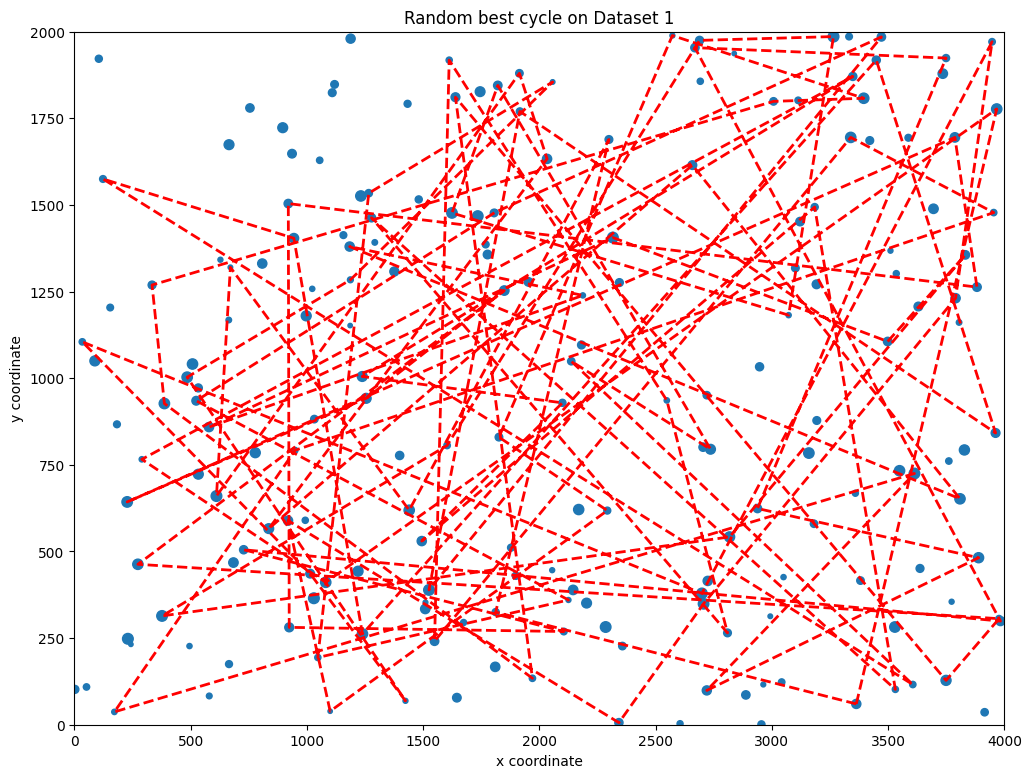

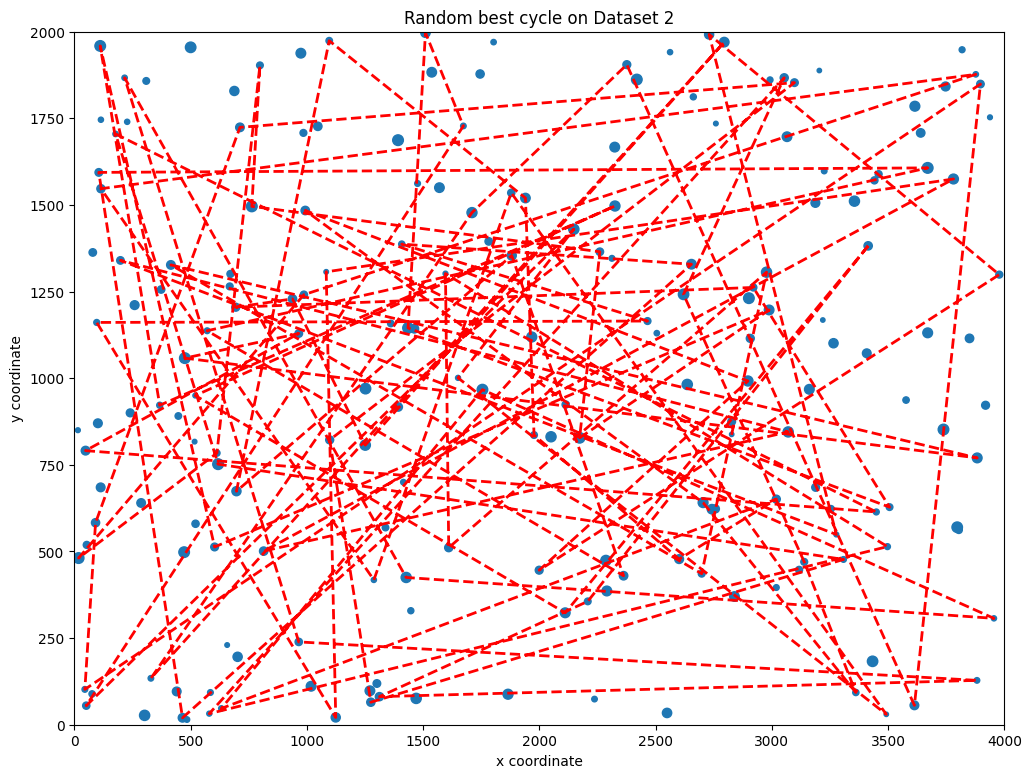

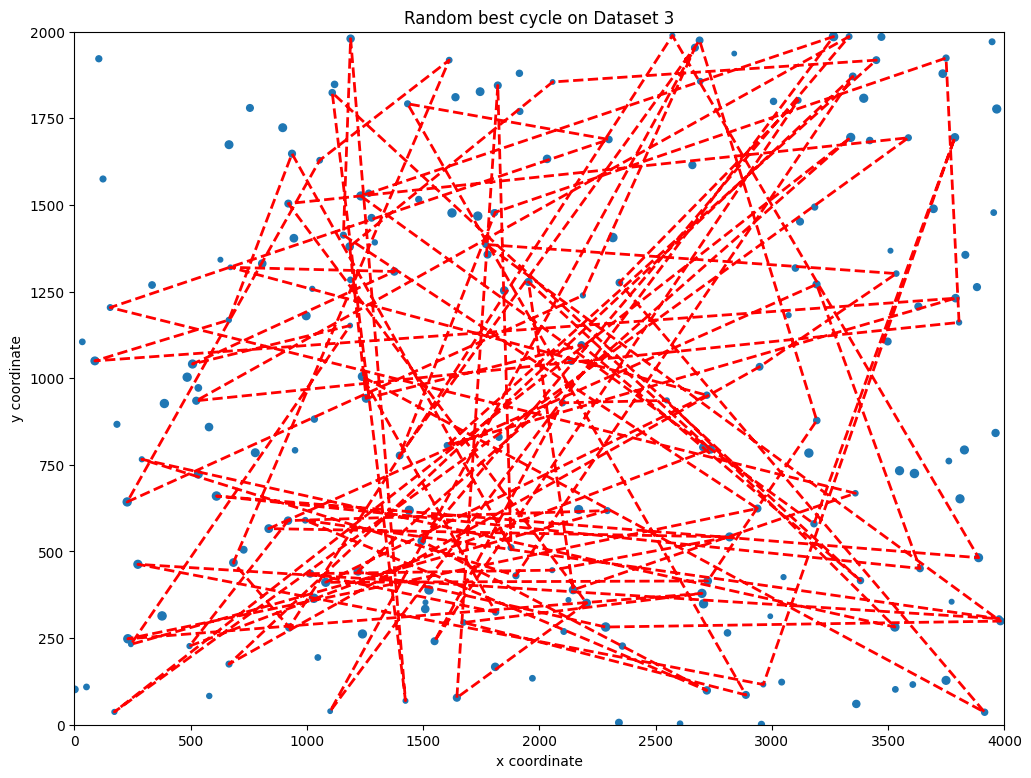

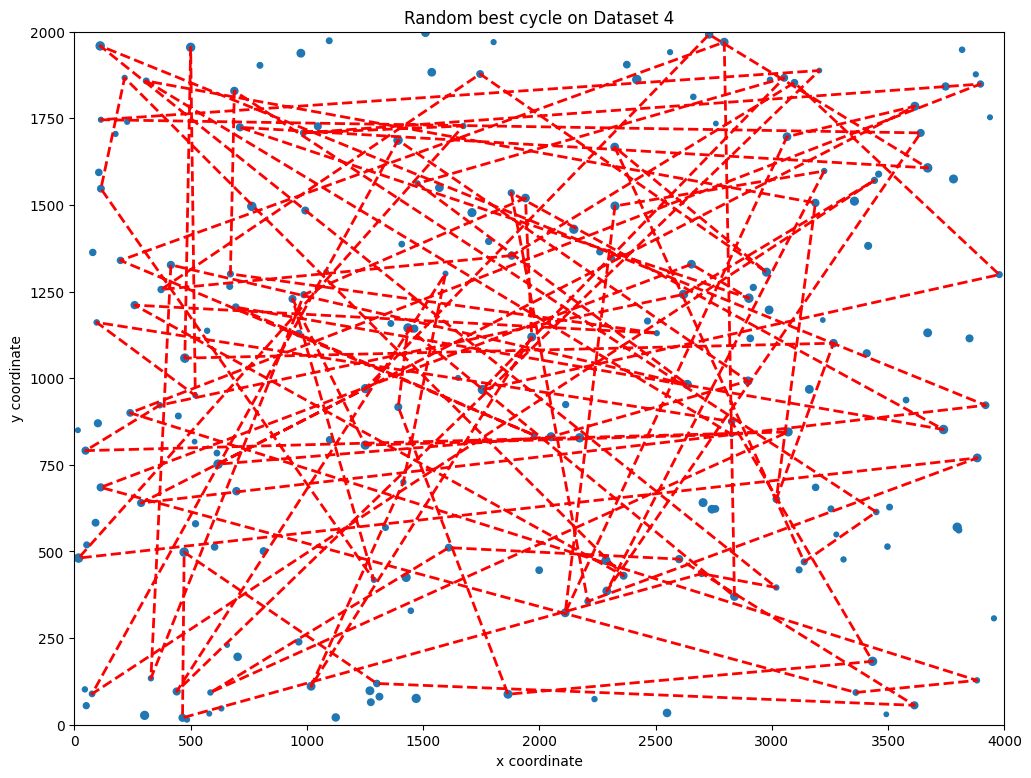

In [ ]:
#for id, df in enumerate([df1, df2, df3, df4]):
#    plot_cycle(df, random_best_paths[id], f"Random best cycle on Dataset {id+1}")

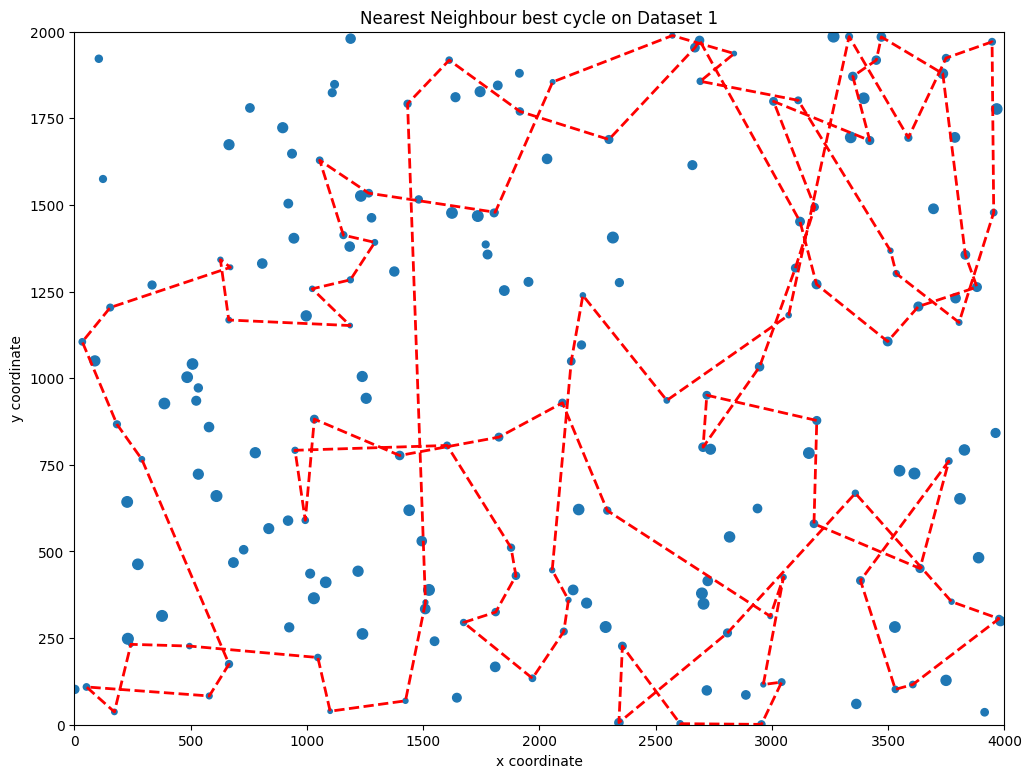

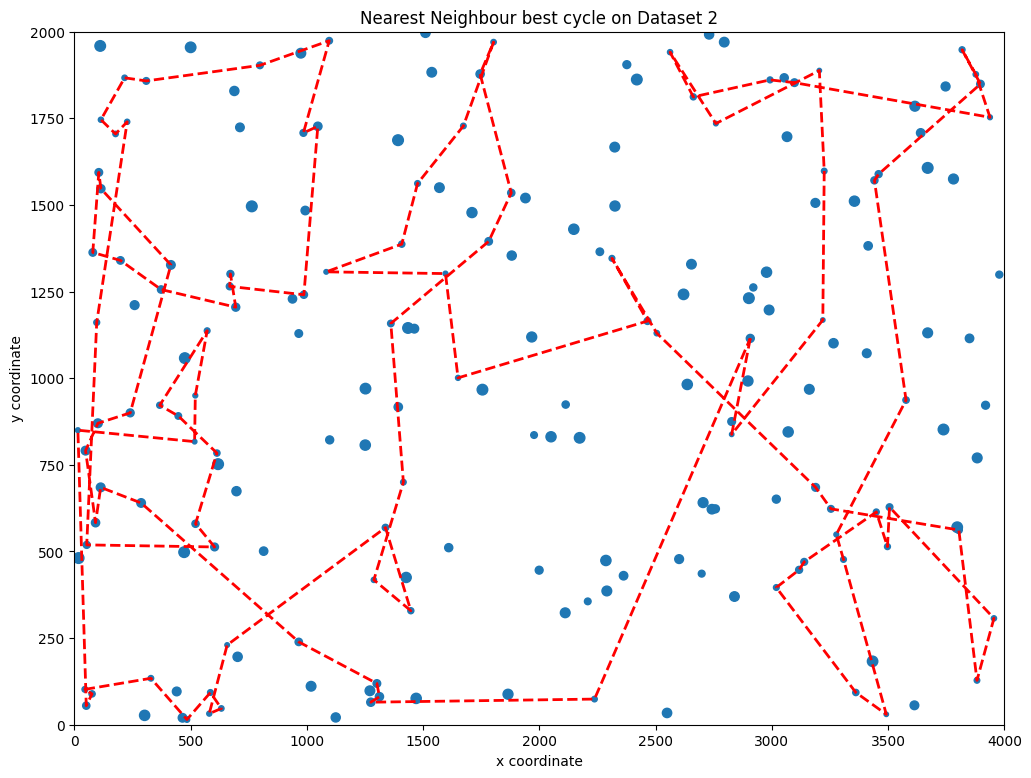

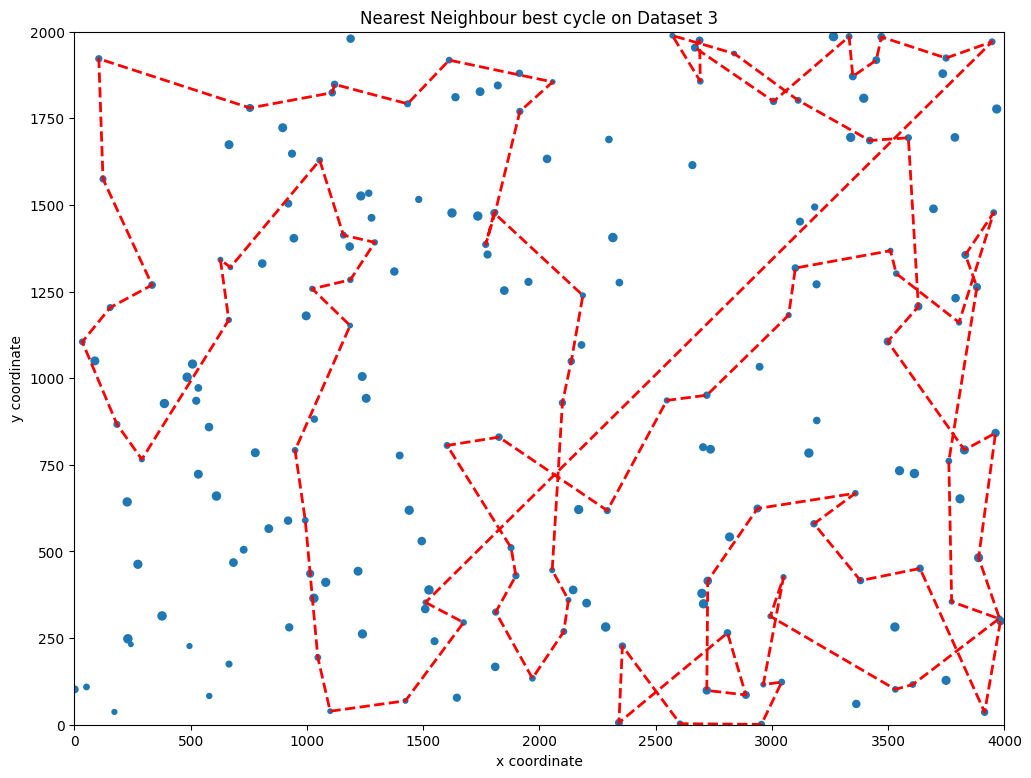

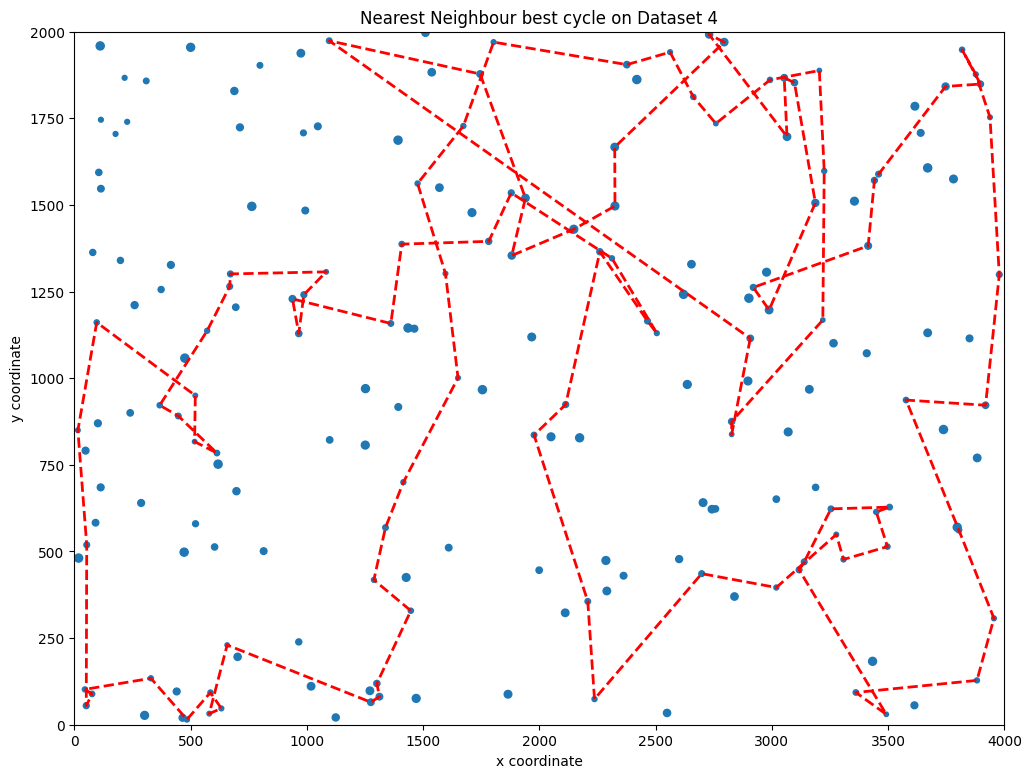

In [ ]:
#for id, df in enumerate([df1, df2, df3, df4]):
#    plot_cycle(df, nearest_best_paths[id], f"Nearest Neighbour best cycle on Dataset {id+1}")

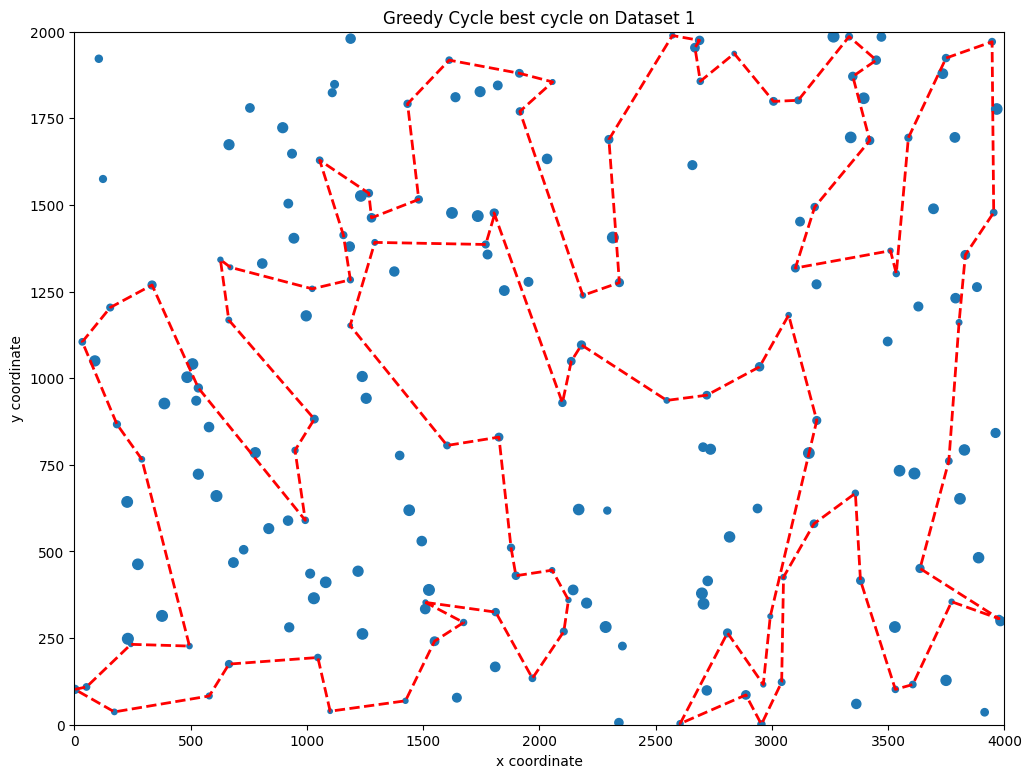

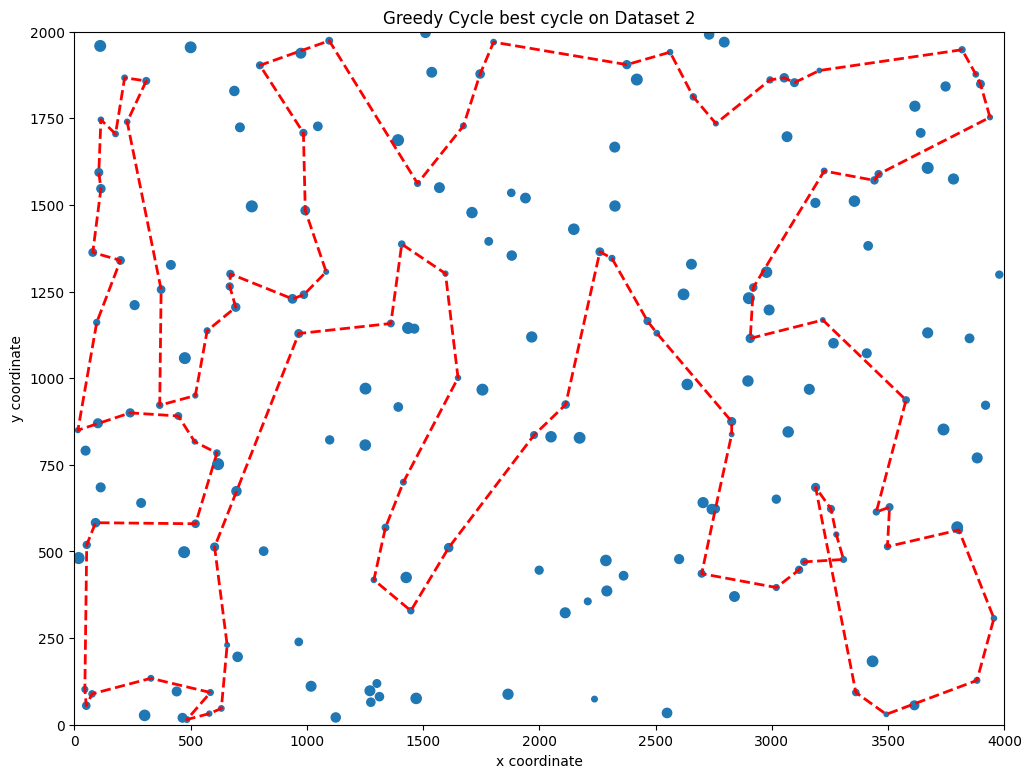

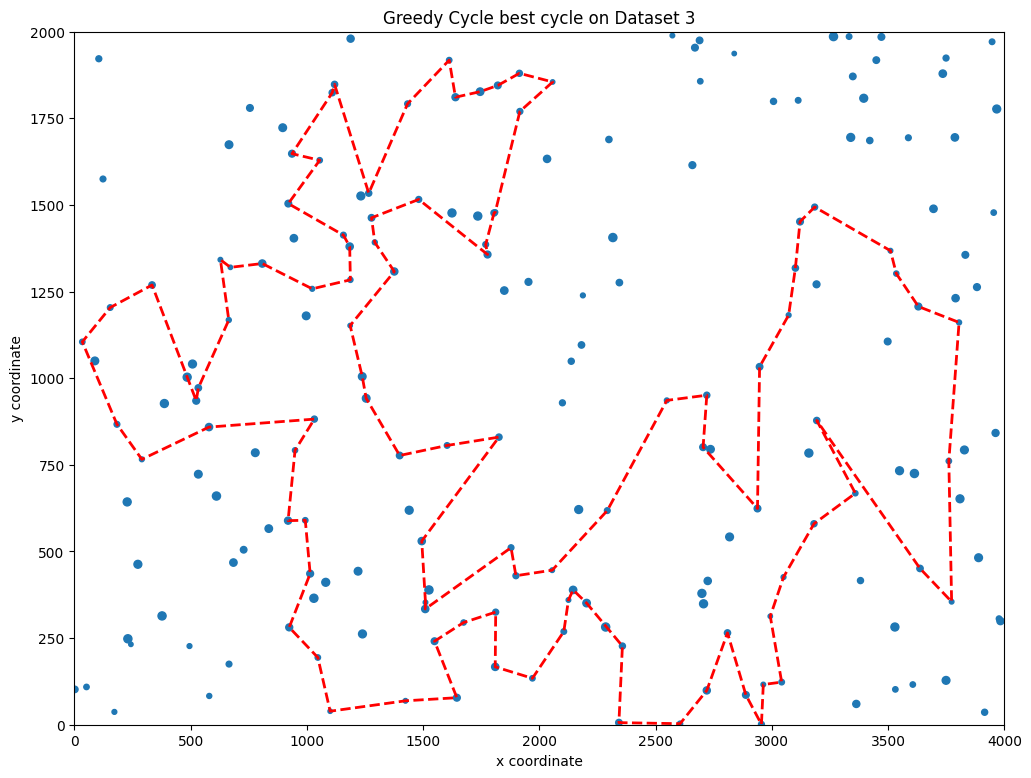

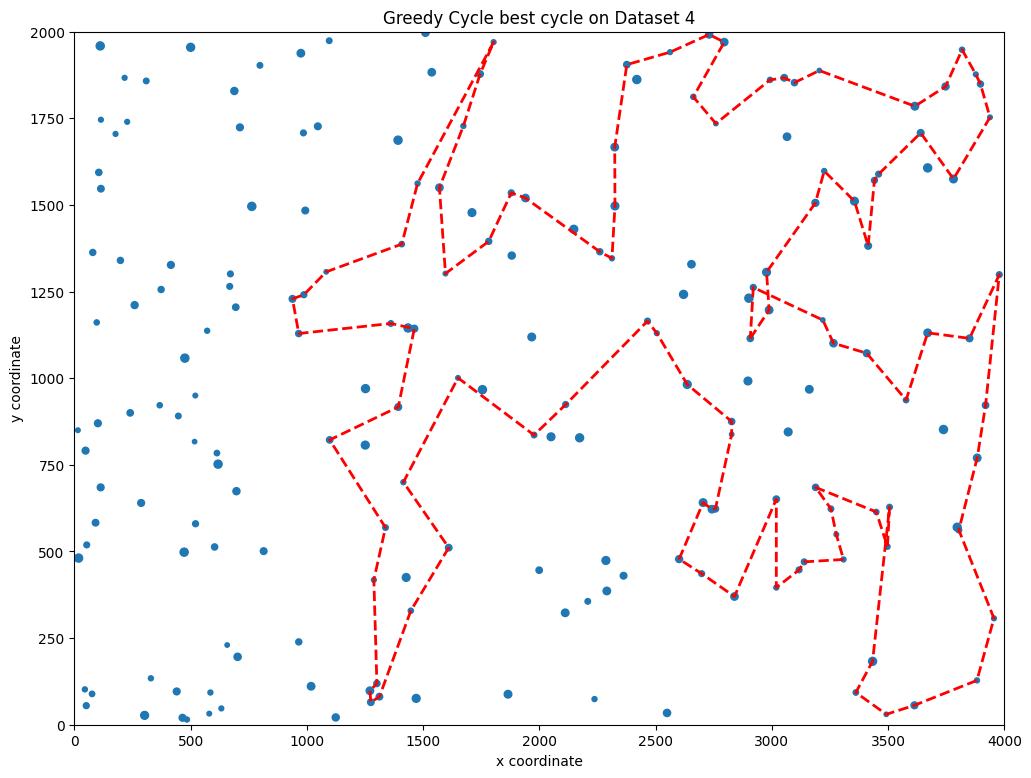

In [ ]:
#for id, df in enumerate([df1, df2, df3, df4]):
#    plot_cycle(df, greedy_best_paths[id], f"Greedy Cycle best cycle on Dataset {id+1}")

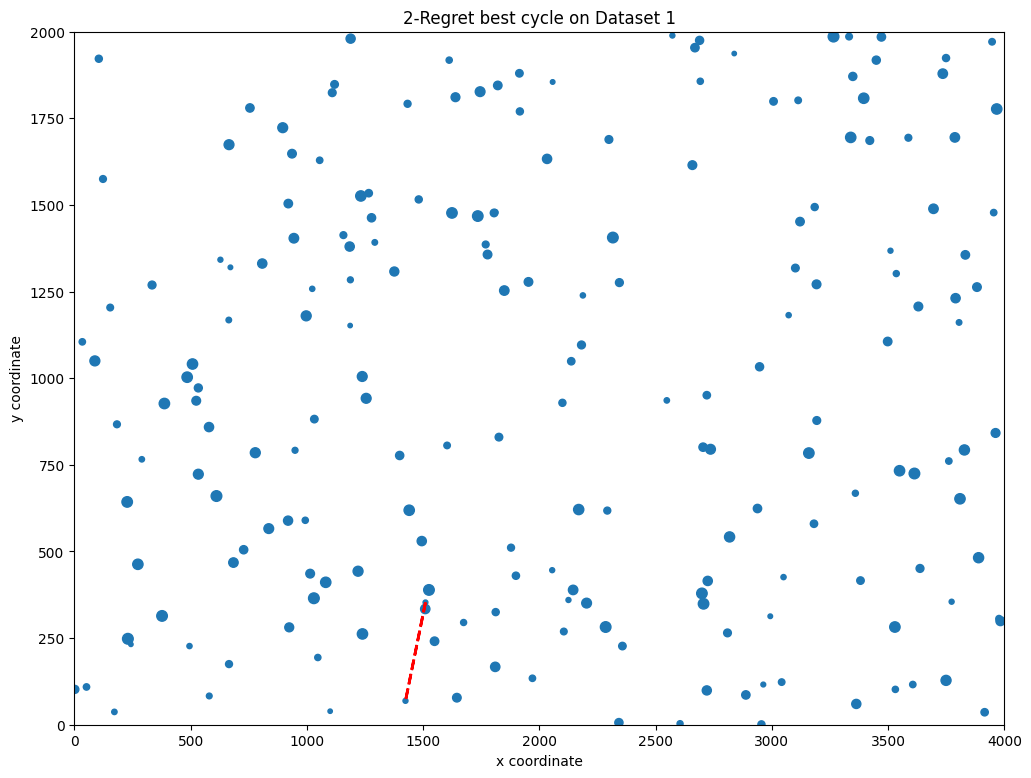

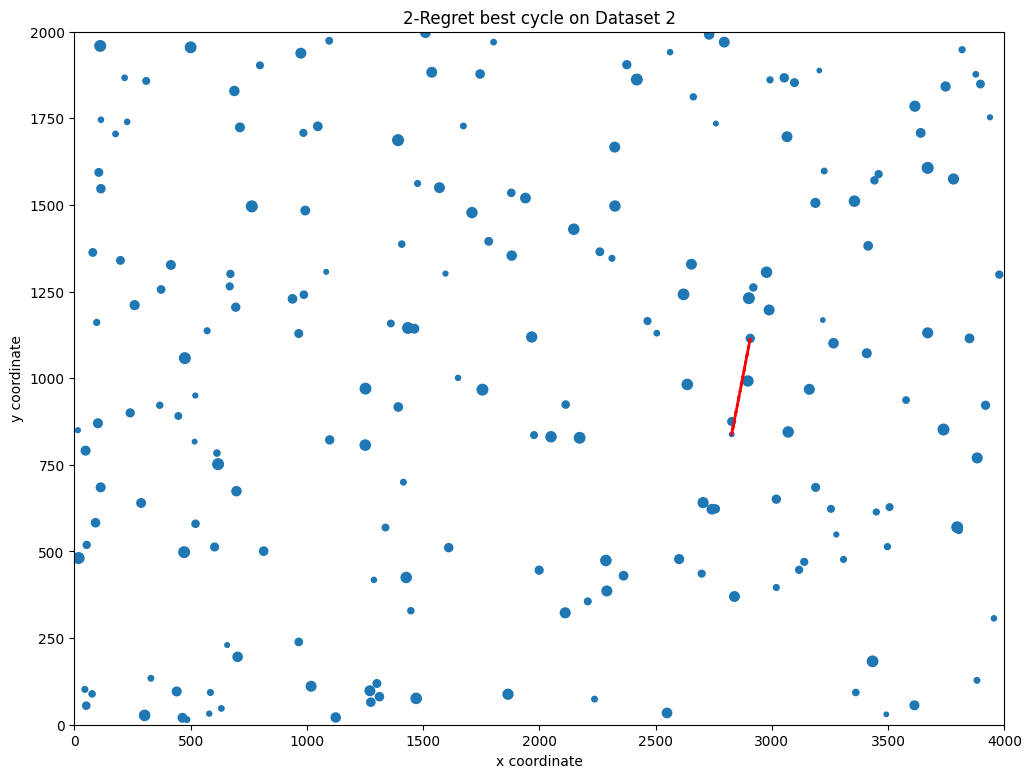

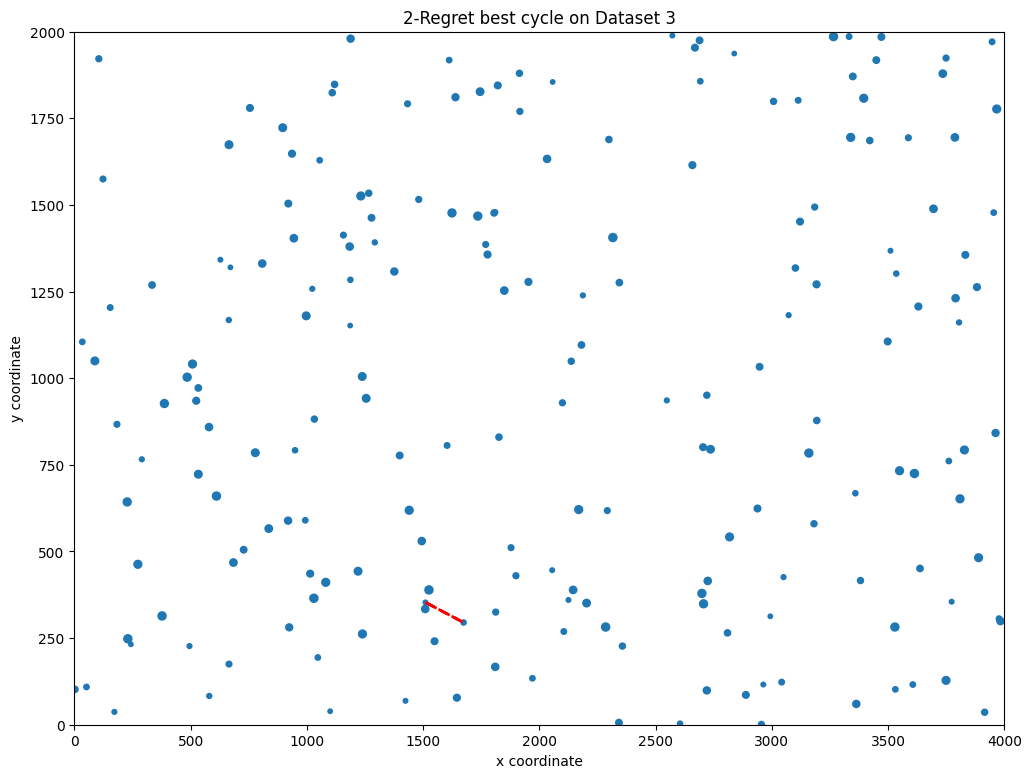

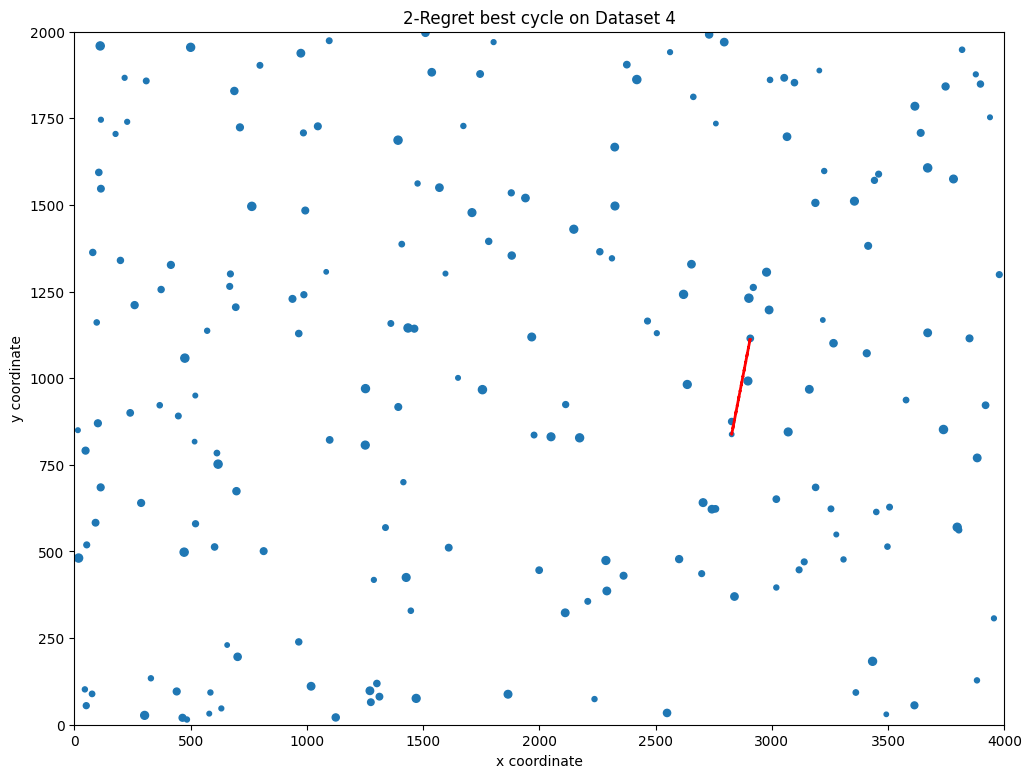

In [ ]:
for id, df in enumerate([df1, df2, df3, df4]):
    plot_cycle(df, regret_best_paths[id], f"2-Regret best cycle on Dataset {id+1}")

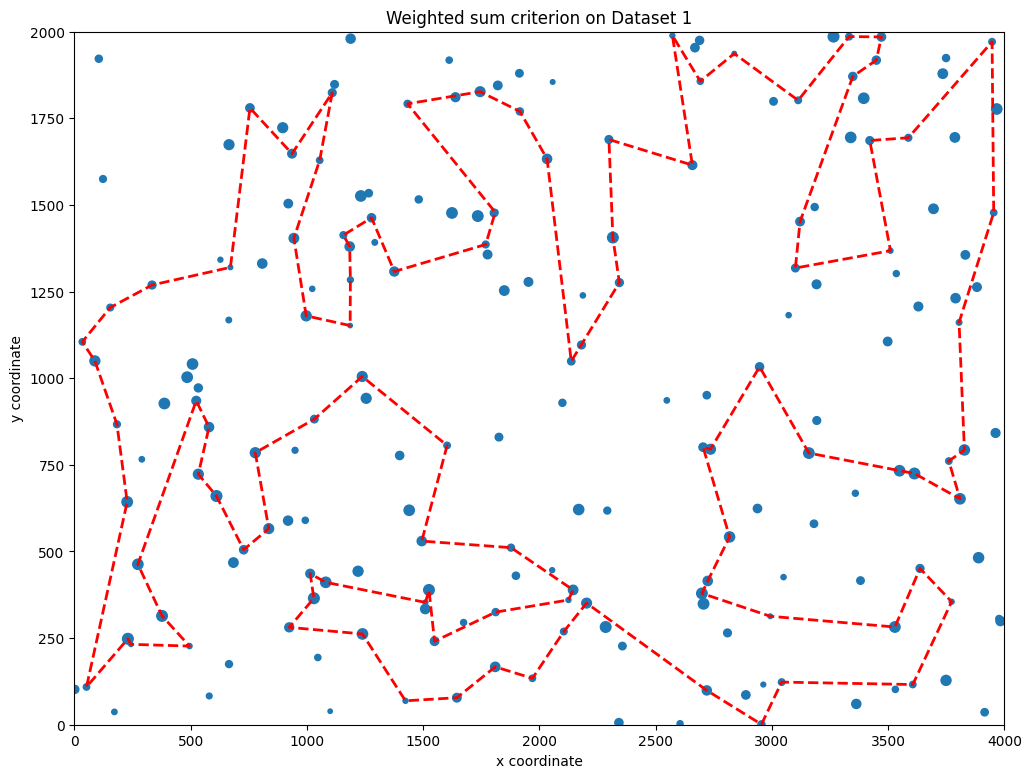

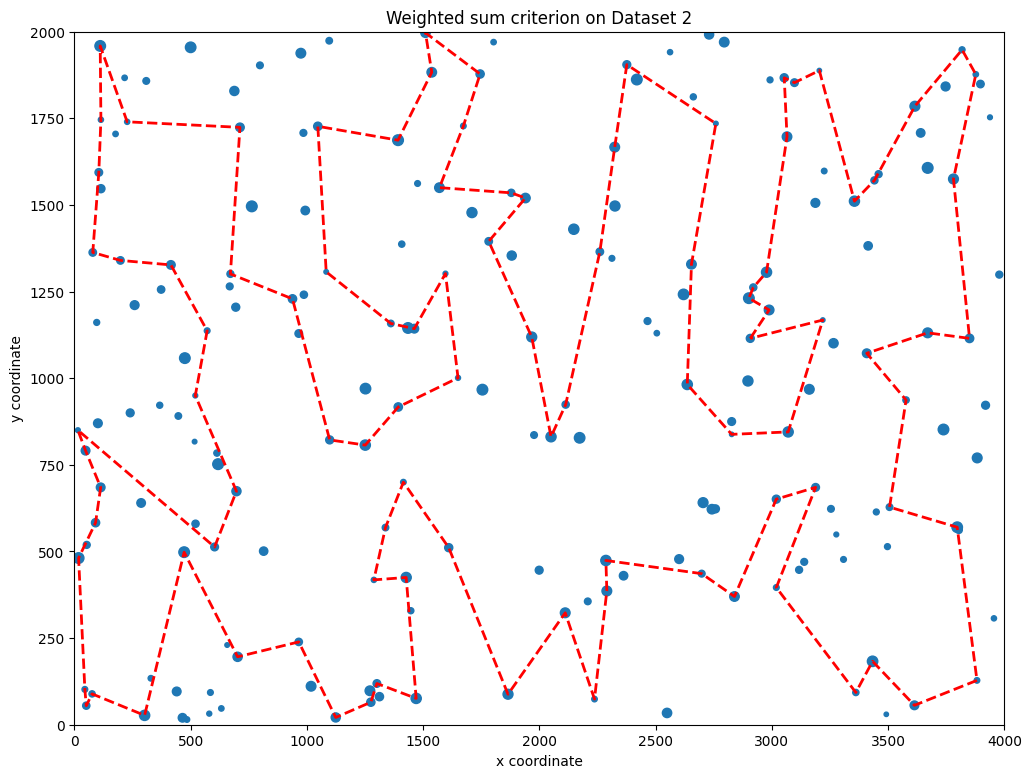

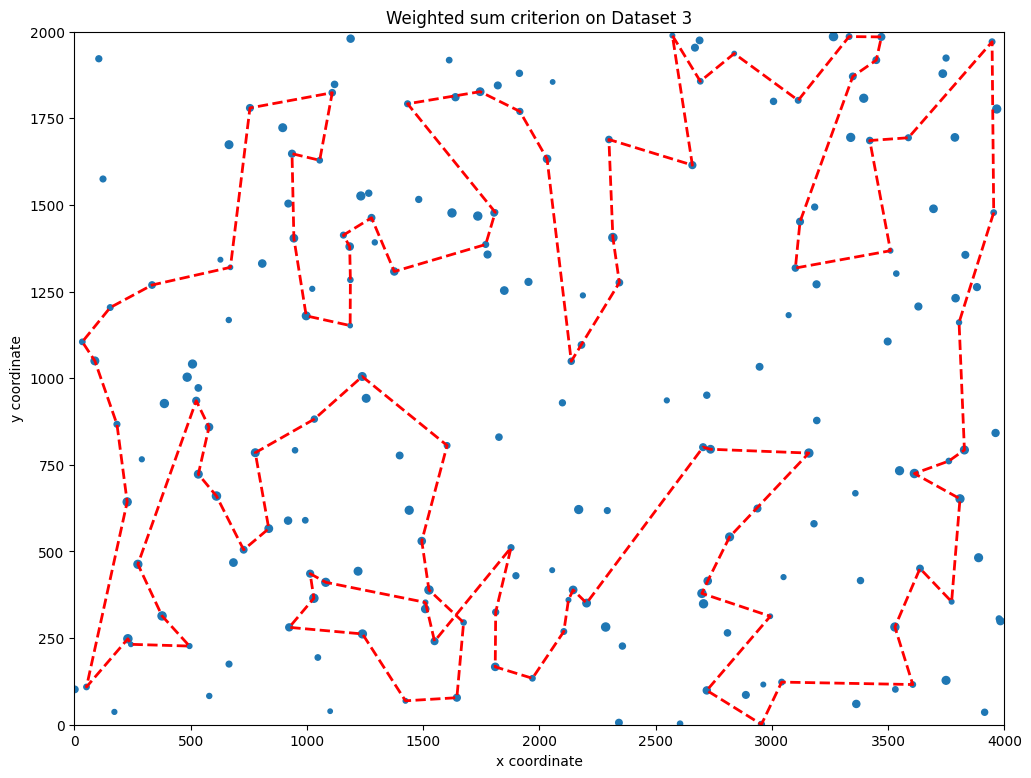

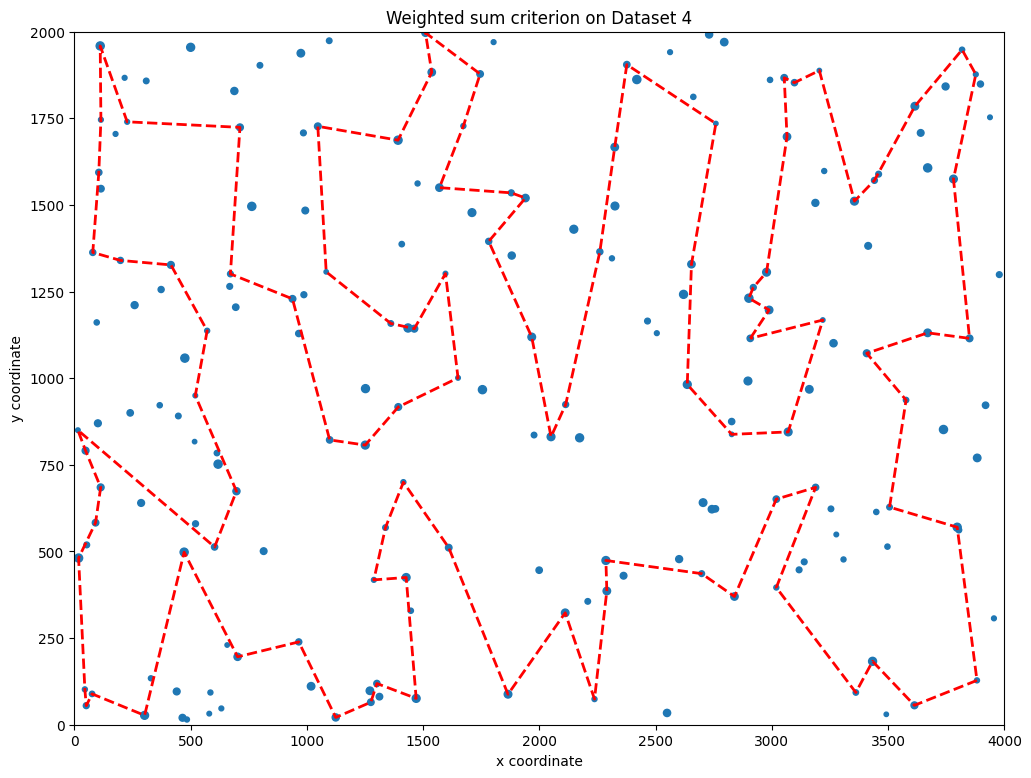

In [ ]:
for id, df in enumerate([df1, df2, df3, df4]):
    plot_cycle(df, weighted_best_paths[id], f"Weighted sum criterion on Dataset {id+1}")